In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
from datetime import datetime
from torchsummary import summary

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])


train_dataset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

In [23]:
val_size = int(len(train_dataset_full) * 0.2)
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = random_split(
    train_dataset_full, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 40000, Val: 10000, Test: 10000


In [24]:
class BetterCNN(nn.Module):
    def __init__(self):
        super(BetterCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout(0.25),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout(0.25),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2, 2), nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BetterCNN().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
           Dropout-8           [-1, 64, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]          73,856
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [27]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    train_loss_list, val_loss_list = [], []
    train_acc_list, val_acc_list = [], []

    best_val_acc = 0.0
    best_model_wts = None

    for epoch in range(num_epochs):
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        # ===== Validation =====
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        scheduler.step(val_loss)

        # Save best model (in memory)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print(f"\n Loaded best model with Val Acc: {best_val_acc:.4f}")

    return model, train_loss_list, val_loss_list, train_acc_list, val_acc_list


model, train_loss, val_loss, train_acc, val_acc = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30
)

Epoch [1/30] Train Acc: 0.3634 | Val Acc: 0.4788 | Train Loss: 1.7103 | Val Loss: 1.4404
Epoch [2/30] Train Acc: 0.5585 | Val Acc: 0.6282 | Train Loss: 1.2212 | Val Loss: 1.0276
Epoch [3/30] Train Acc: 0.6377 | Val Acc: 0.6722 | Train Loss: 1.0235 | Val Loss: 0.8989
Epoch [4/30] Train Acc: 0.6889 | Val Acc: 0.7192 | Train Loss: 0.8924 | Val Loss: 0.7955
Epoch [5/30] Train Acc: 0.7236 | Val Acc: 0.7440 | Train Loss: 0.7972 | Val Loss: 0.7285
Epoch [6/30] Train Acc: 0.7487 | Val Acc: 0.6714 | Train Loss: 0.7317 | Val Loss: 1.0536
Epoch [7/30] Train Acc: 0.7696 | Val Acc: 0.7690 | Train Loss: 0.6761 | Val Loss: 0.6646
Epoch [8/30] Train Acc: 0.7862 | Val Acc: 0.7909 | Train Loss: 0.6272 | Val Loss: 0.6163
Epoch [9/30] Train Acc: 0.8063 | Val Acc: 0.8118 | Train Loss: 0.5748 | Val Loss: 0.5513
Epoch [10/30] Train Acc: 0.8190 | Val Acc: 0.8021 | Train Loss: 0.5347 | Val Loss: 0.5751
Epoch [11/30] Train Acc: 0.8304 | Val Acc: 0.8274 | Train Loss: 0.5022 | Val Loss: 0.5152
Epoch [12/30] Train

Test Accuracy: 0.8886


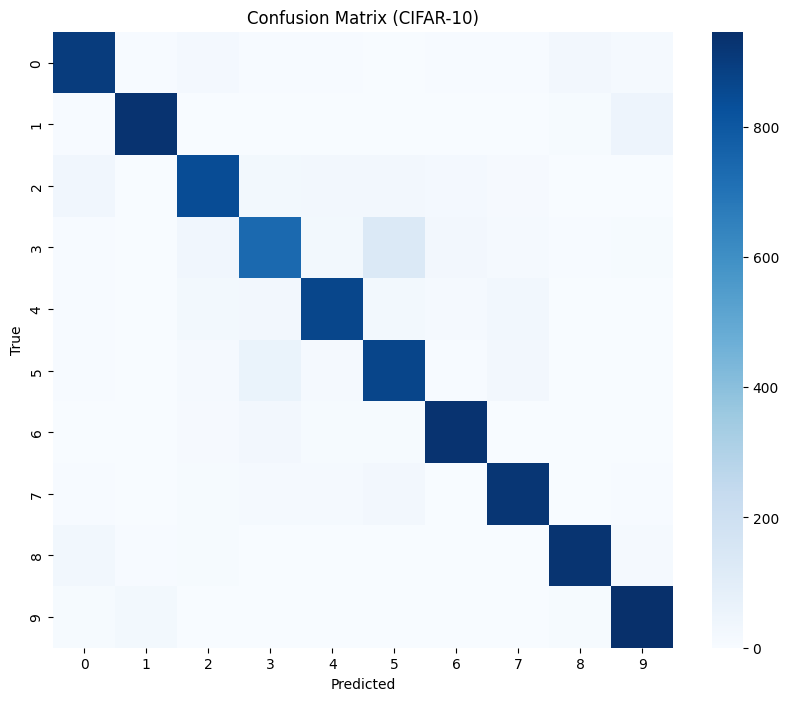


Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.90      0.90      1000
  automobile       0.95      0.93      0.94      1000
        bird       0.87      0.84      0.86      1000
         cat       0.82      0.74      0.78      1000
        deer       0.90      0.87      0.88      1000
         dog       0.79      0.87      0.83      1000
        frog       0.92      0.93      0.93      1000
       horse       0.90      0.92      0.91      1000
        ship       0.94      0.93      0.93      1000
       truck       0.90      0.95      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [28]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# --- Evaluation Phase ---
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- Accuracy ---
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(all_labels, all_preds)
classes = test_loader.dataset.classes  # รายชื่อคลาสของ CIFAR-10

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix (CIFAR-10)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))


In [29]:
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_path = os.path.join(save_dir, f"BetterCNN_CIFAR10_{timestamp}.pth")

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_acc,
    'val_accuracy': max(val_acc),
    'epoch': len(train_loss),
    'model_architecture': 'BetterCNN'
}, model_path)

print(f"Model saved to: {model_path}")


Model saved to: ./saved_models/BetterCNN_CIFAR10_20251018_095425.pth
